In [10]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

AUDIO_DIR = Path("data3/")
SAMPLE_RATE = 44100
SEGMENT_DURATION = 4.0
OVERLAP_RATIO = 0.75
SEGMENT_SAMPLES = int(SAMPLE_RATE * SEGMENT_DURATION)
STEP_SIZE = int(SEGMENT_SAMPLES * (1 - OVERLAP_RATIO))
MIN_RMS_THRESHOLD = 0.01


In [14]:
file_stats = []

for file in AUDIO_DIR.rglob("*.wav"):
    try:
        audio, sr = torchaudio.load(str(file))

        # Resample if needed
        if sr != SAMPLE_RATE:
            audio = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(audio)

        # Convert mono to stereo
        if audio.shape[0] == 1:
            audio = torch.cat([audio, audio], dim=0)

        duration_sec = audio.shape[1] / SAMPLE_RATE
        channels = audio.shape[0]
        mean_rms = audio.std().item()
        peak = audio.abs().max().item()
        expected_segments = int((duration_sec - SEGMENT_DURATION) // STEP_SIZE + 1)

        file_stats.append({
            "filename": file.name,
            "duration_sec": round(duration_sec, 2),
            "channels": channels,
            "mean_rms": round(mean_rms, 4),
            "peak_amplitude": round(peak, 4),
            "expected_segments": expected_segments,
            "is_silent": mean_rms < MIN_RMS_THRESHOLD
        })

    except Exception as e:
        print(f"❌ Error loading {file.name}: {e}")

# Create DataFrame
df = pd.DataFrame(file_stats)

# Show head
df

,filename,duration_sec,channels,mean_rms,peak_amplitude,expected_segments,is_silent
0,YB1.wav,105.02,2,0.3121,1.0373,1,False
1,YB3.wav,105.02,2,0.2644,1.0192,1,False
2,YB4.wav,122.95,2,0.2538,1.0181,1,False
3,YB2.wav,108.77,2,0.3168,1.0203,1,False


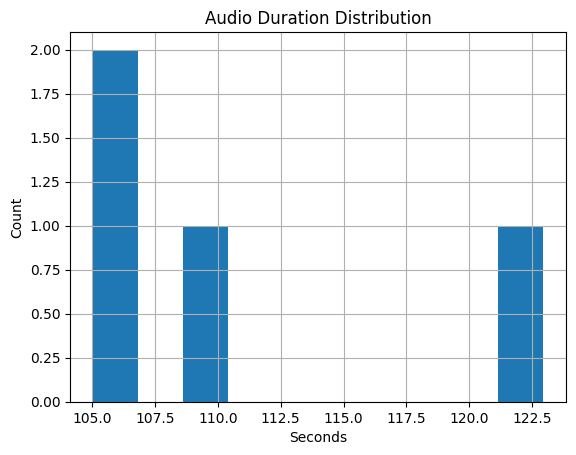

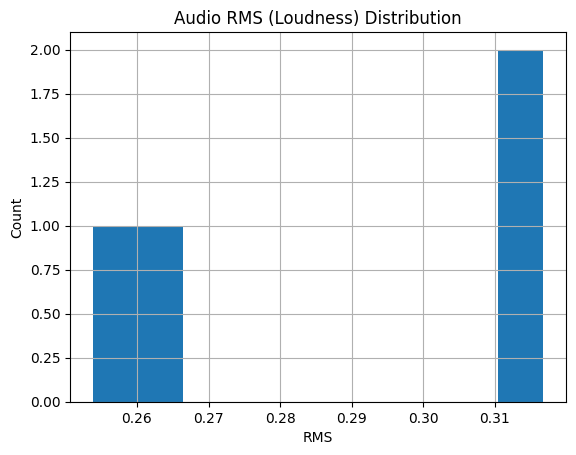

In [15]:
import matplotlib.pyplot as plt

# Duration
df["duration_sec"].hist(bins=10)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# RMS
df["mean_rms"].hist(bins=10)
plt.title("Audio RMS (Loudness) Distribution")
plt.xlabel("RMS")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [16]:
total_segments = df["expected_segments"].sum()
silent_segments = df[df["is_silent"]]["expected_segments"].sum()
usable_segments = total_segments - silent_segments

print(f"Total possible segments (pre-filter): {total_segments}")
print(f"Segments skipped due to silence: {silent_segments}")
print(f"Final usable segments: {usable_segments}")


Total possible segments (pre-filter): 4
Segments skipped due to silence: 0
Final usable segments: 4


📈 Displaying: YB1.wav


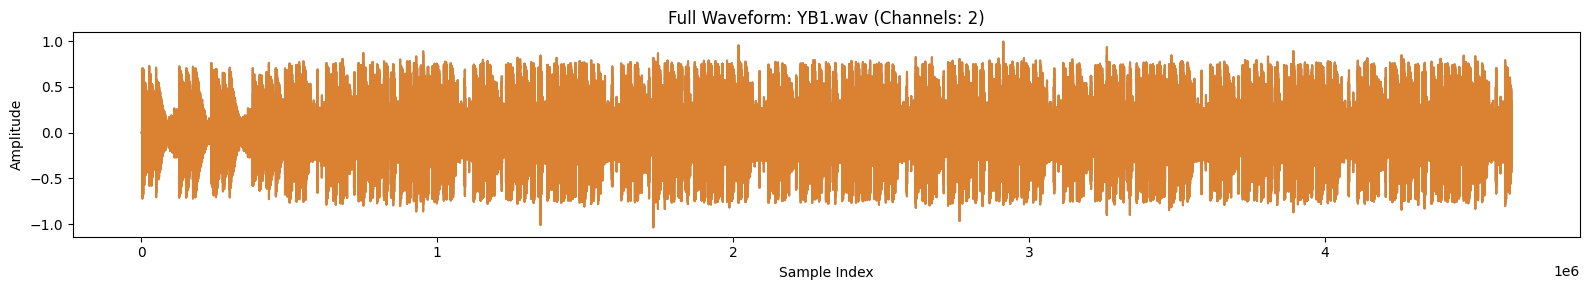

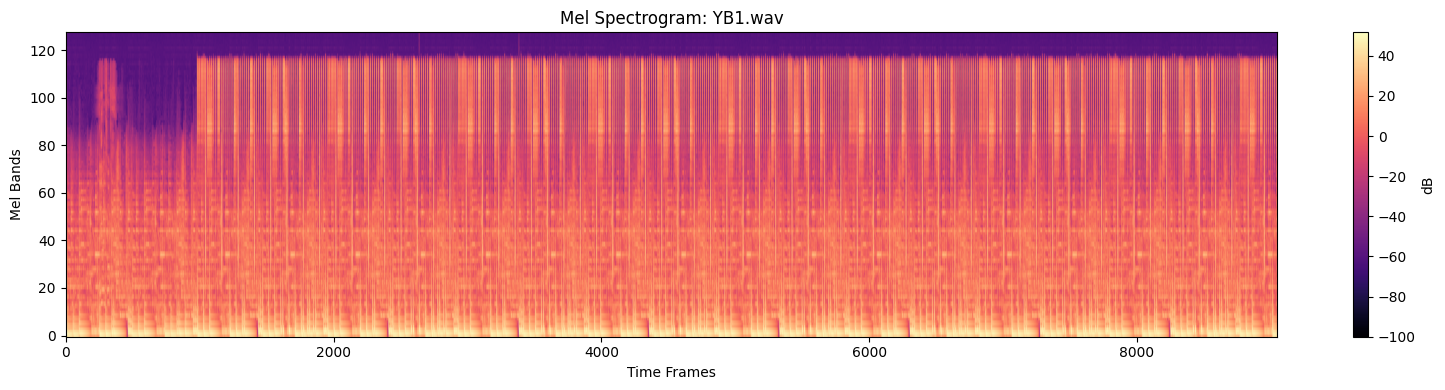

📈 Displaying: YB3.wav


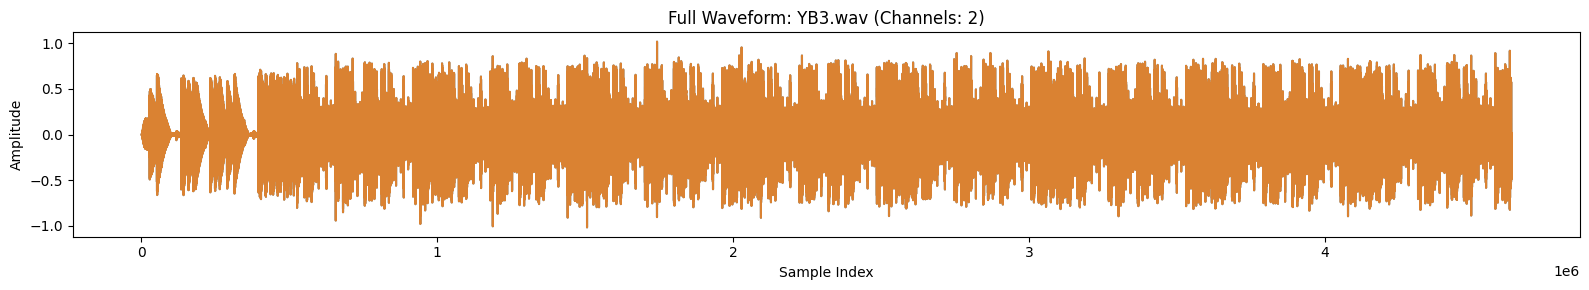

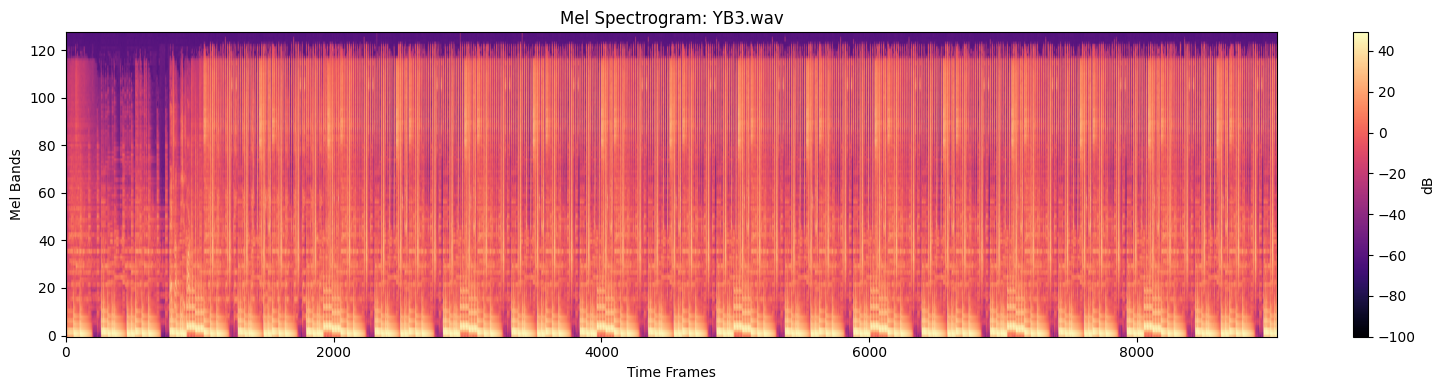

📈 Displaying: YB4.wav


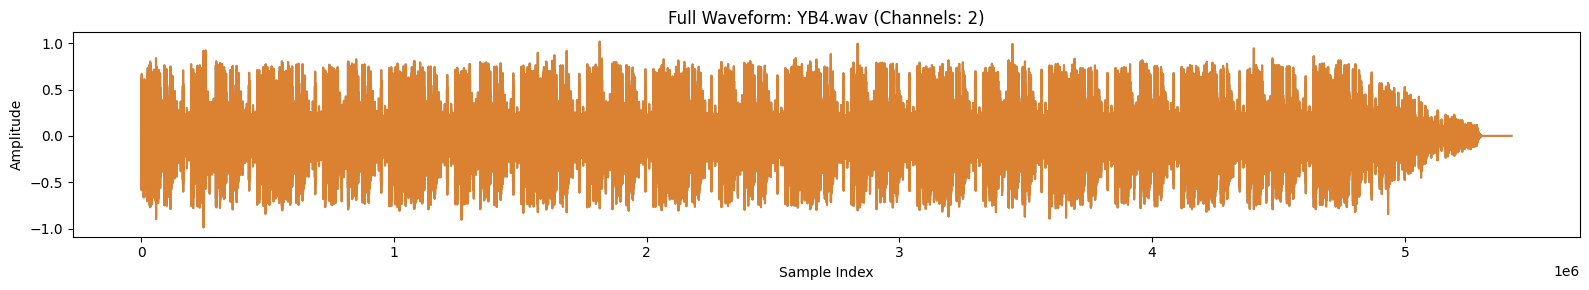

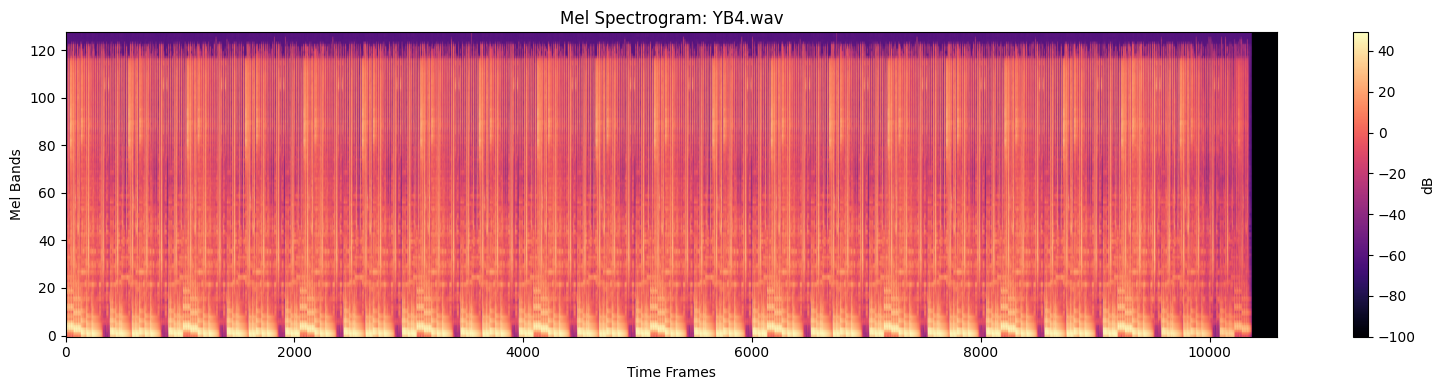

📈 Displaying: YB2.wav


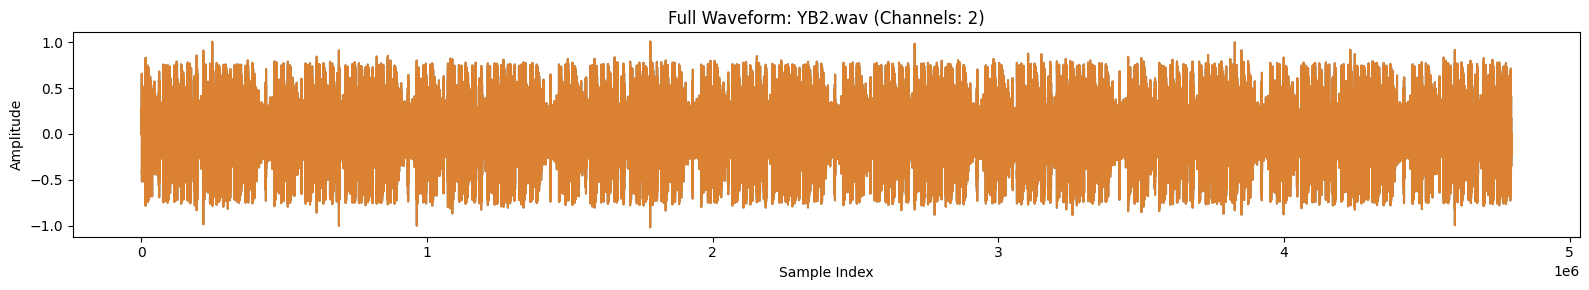

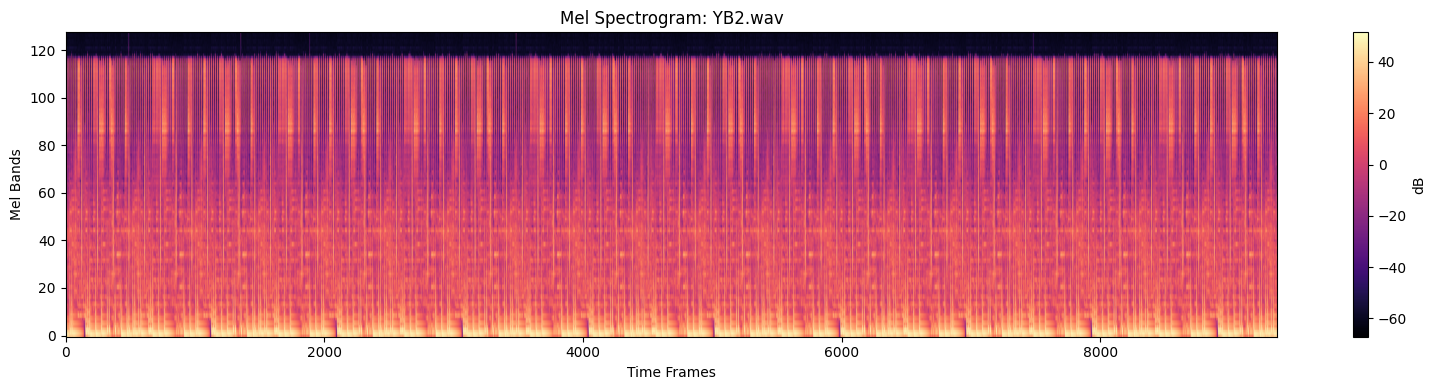

In [20]:
def plot_full_waveform_and_spec(file_path):
    audio, sr = torchaudio.load(str(file_path))
    
    if sr != SAMPLE_RATE:
        audio = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(audio)

    if audio.shape[0] == 1:
        audio = torch.cat([audio, audio], dim=0)  # force stereo

    # Plot full waveform (no legend to avoid slowdown)
    plt.figure(figsize=(16, 3))
    colors = ['tab:blue', 'tab:orange']
    for i in range(audio.shape[0]):
        plt.plot(audio[i].numpy(), color=colors[i], alpha=0.8)
    plt.title(f"Full Waveform: {file_path.name} (Channels: {audio.shape[0]})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Compute and plot mel spectrogram
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=2048,
        hop_length=512
    )(audio[0].unsqueeze(0))
    
    mel_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)

    plt.figure(figsize=(16, 4))
    plt.imshow(mel_db[0].cpu().numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Mel Spectrogram: {file_path.name}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Bands")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.show()

# 🚀 Plot for all .wav files
wav_files = list(AUDIO_DIR.rglob("*.wav"))

if not wav_files:
    print("❌ No .wav files found in the directory.")
else:
    for file in wav_files:
        print(f"📈 Displaying: {file.name}")
        plot_full_waveform_and_spec(file)